# Transformación pasabanda
<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

## Resumen 

En este documento presentamos el uso de las siguientes funciones para el análisis de la transformación pasabanda de funciones transferencia:

De análisis y visualización

* [analyze_sys](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.analyze_sys)
* [bodePlot](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.bodePlot)
* [pzmap](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pzmap)
* [GroupDelay](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.GroupDelay)


De manipulación de sistemas lineales

* [tf2sos_analog](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.tf2sos_analog)
* [parametrize_sos](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.parametrize_sos)

De presentación algebraica

* [pretty_print_bicuad_omegayq](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pretty_print_bicuad_omegayq)
* [pretty_print_lti](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pretty_print_lti)
* [pretty_print_SOS](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.pretty_print_SOS)
* [print_subtitle](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.print_subtitle)
* [print_latex](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.print_latex)
* [a_equal_b_latex_s](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/general/index.html#pytc2.general.a_equal_b_latex_s)


## Introducción

A esta altura del curso, hemos diseñado filtros pasabajo normalizados de orden arbitrario, dependiendo de las restricciones de módulo o retardo impuestas por el problema. Extendemos el problema de diseñar *cualquier* tipo de función transferencia (pasa-alto, pasabanda, etc) al siguiente procedimiento:

1. Identificar el tipo de filtro requerido por la plantilla original (atenuación o módulo de la transferencia)
2. Convertir la plantilla del filtro, mediante el núcleo de transformación adecuado, a una plantilla pasabajo.
3. Diseñar una función transferencia pasabajo normalizada.
4. Aplicar un núcleo de transformación adecuado.

Este documento se centra en analizar el comportamiento del núcleo de transformación **pasabanda normalizado**. Para ello recordamos su expresión:

$$ K_{bp}(s) = Q_{bp} * \frac{s^2 + 1}{s} $$

Usamos $p$ como variable compleja en el dominio del prototipo pasabajo (2do paso) solo para señalar que *no* se trata de la misma variable, ni transferencia. Luego al llegar al paso 4, podemos obtener la transferencia pasabanda como

$$ T_{bp}(s) = T_{Lp}(p)\Big\vert_{p = K_{bp}} = (T_{Lp1}(p)\cdot \prod_{k=1}^{N} T_{Lp2_k}(p))\Big\vert_{p = K_{bp}}$$

También se sabe que para una transferencia $T(s)$ de orden arbitrario, la misma se puede expresar como el producto de $N$ secciones de segundo orden (SOS), y eventualmente en el caso que el orden fuera impar, una sección de primer orden. Por este motivo en este documento analizaremos el comportamiento del núcleo exclusivamente para secciones de primer y segundo orden. El comportamiento para un orden arbitrario, se podrá deducir del comportamiento para cada sección individual.


## Prototipo pasabajos de primer orden

Sea la función transferencia de un *filtro prototipo pasabajo*

$$ T_{Lp} = \frac{k.a}{p + a}, $$

siendo $a$ un número real que indica la pulsación de corte, y $k$ la ganancia para $p = 0$, entonces 

$$ T_{bp}(s) = T_{Lp}(p)\Big\vert_{p = K_{bp}} $$

$$ T_{bp}(s) = \frac{a}{ Q_{bp} * \frac{s^2 + 1}{s} + a} $$


$$ T_{bp}(s) = \frac{s . k . \frac{a}{Q_{bp}} }{s^2 + s . \frac{a}{Q_{bp}} + 1} $$

Como se observa, se llega a un filtro pasabanda normalizado donde se puede apreciar:

* El centro de la banda de paso se encuentra en $\omega_0 = 1$
* La ganancia en el centro de la banda de paso depende de $k$
* El Q del pasabanda resultante estará dado por $Q = \frac{Q_{bp}}{a}$

En el siguiente ejemplo se mostrará cómo llegar a estos resultados a partir de las herramientas de simulación simbólica y numérica.

In [1]:
# Módulos externos

import sympy as sp
from sympy.abc import s

import matplotlib as mpl
import matplotlib.pyplot as plt

fig_sz_x = 13
fig_sz_y = 7
fig_dpi = 80 # dpi

fig_font_size = 11

mpl.rcParams['figure.figsize'] = (fig_sz_x, fig_sz_y)
mpl.rcParams['figure.dpi'] = fig_dpi
plt.rcParams.update({'font.size':fig_font_size})

import numpy as np
import scipy.signal as sig
from IPython.display import display, Markdown

In [2]:
# Ahora importamos las funciones de PyTC2

from pytc2.sistemas_lineales import analyze_sys, parametrize_sos, pretty_print_lti, pretty_print_bicuad_omegayq, tf2sos_analog, pretty_print_SOS
from pytc2.general import print_latex, print_subtitle, a_equal_b_latex_s


Con todas las herramientas cargadas, se continúa a la definición de las funciones simbólicas con las que se realizarán las primeras pruebas:

In [3]:
# Comienzo de la simulación

Q_bp, a, b, k = sp.symbols("Q_bp, a, b, k", complex = False)

############################################
# Definicion de las funciones transferencia. 

H1 = k * a/(s + a)

# nucleo de transformación pasabanda
Kbp = Q_bp * (s**2 + 1) / s


# Análisis de la transformación pasabanda para una transferencia de primer orden.
H1bp = sp.simplify(sp.expand(H1.subs(s, Kbp)))
num, den = sp.fraction(H1bp)
num = sp.Poly(num,s)
den = sp.Poly(den,s)
num1_bp, den1_bp, w1_on, Q1_n, w1_od, Q1_d, K1_bp  = parametrize_sos(num, den)

print_subtitle('Prototipo de primer orden')

print_latex('$ T(s) = ' + sp.latex(H1) + '$')

print_subtitle('Pasabanda obtenido')

print_latex(a_equal_b_latex_s('$ T(s) |_{s = ' + sp.latex(Kbp) +  ' }', '\\frac{ ' + sp.latex(num1_bp.as_expr()) + '}{' + sp.latex(den1_bp.as_expr()) + '}' ))



#### Prototipo de primer orden

<IPython.core.display.Math object>

#### Pasabanda obtenido

<IPython.core.display.Math object>

luego de esta pequeña demostración de las capacidades de manejo simbólico se realizará una simulación numérica

### Análisis numérico

Ahora se procede a cargar los coeficientes del prototipo pasabajos y se usarán las funciones de transformación provistas en *scipy.signal*. Para ello se define $Q_{bp}$

In [6]:
# coeficientes de la transferencia de primer orden T1
T1_num = np.array([1])
T1_den = np.array([1, 1])

# Q de la transformación
Q_bp = 5

# núcleo LP-BP
num_pbanda, den_pbanda = sig.lp2bp(T1_num, T1_den, bw = 1/Q_bp)

print_subtitle('Prototipo de primer orden')

print_latex(a_equal_b_latex_s('$ T_{lp}(s)', sp.latex( 1/(s + 1) )))

print_subtitle('Pasabanda obtenido para Q={:d} (coeficientes de los polinomios)'.format(Q_bp))

print(num_pbanda)
print(den_pbanda)

#### Prototipo de primer orden

<IPython.core.display.Math object>

#### Pasabanda obtenido para Q=5 (coeficientes de los polinomios)

[0.2 0. ]
[1.  0.2 1. ]


Como se observa, la visualización de los coeficientes no solo es complicada de interpretar, sino que tampoco escala bien con la complejidad y orden de la función. Para ello se presenta otra alternativa implementada en *pytc2*

In [5]:

print_subtitle('Como cociente de polinomios')

# forma un poco más clara
print_latex(a_equal_b_latex_s('T_{bp}(s)', pretty_print_lti(num_pbanda, den_pbanda, displaystr=False)))


#### Como cociente de polinomios

<IPython.core.display.Math object>

Esta alternativa está mucho más cerca de la forma matemática en que se suele interpretar, sin embaro, aprovechando las posibilidades algebraicas de *SymPy*, podemos reordenarlo

In [6]:
print_subtitle('Factorizado con $\omega_0$ y $Q$')

# esta es la que va
print_latex(a_equal_b_latex_s('T_{bp}(s)', pretty_print_bicuad_omegayq(num_pbanda, den_pbanda, displaystr=False)))


#### Factorizado con $\omega_0$ y $Q$

<IPython.core.display.Math object>

De esta manera la comparación se ve facilitada, si recordamos que al transofrmar una transferencia prototipo de primer orden se obtiene una SOS

$$ T_{bp}(s) = \frac{s . k . \frac{a}{Q_{bp}} }{s^2 + s . \frac{a}{Q_{bp}} + 1} $$


entonces los parámetros serán

* $ \omega_0 = 1 $
* $Q = \frac{Q_{bp}}{a} = Q_{bp} = 5$
* $ K = 1 $

![messirve](messirve.jpeg)


Confirmamos que llegamos a la función transferencia pasabanda de $\omega_0=1$ y $Q=5$ como se definió en el núcleo de transformación.

### Análisis de la respuesta en frecuencia

Continuando con el análisis numérico de este pasabanda, analizaremos la respuesta en frecuencia

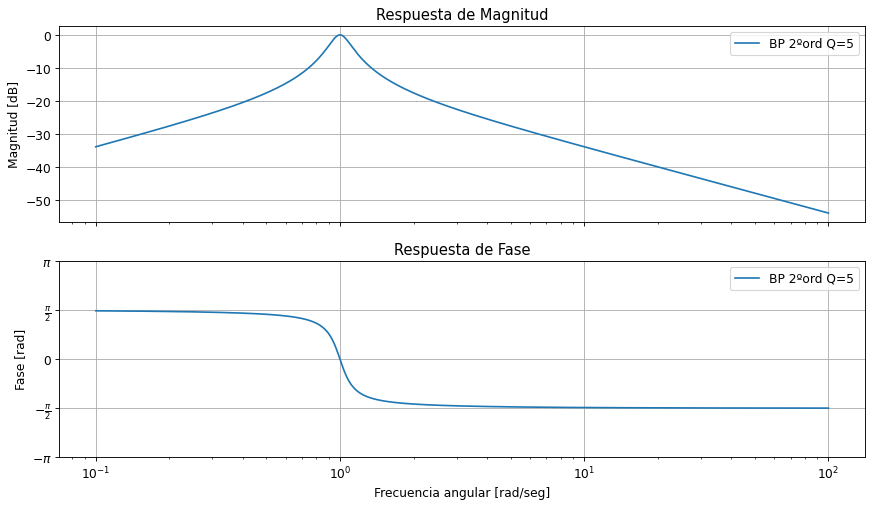

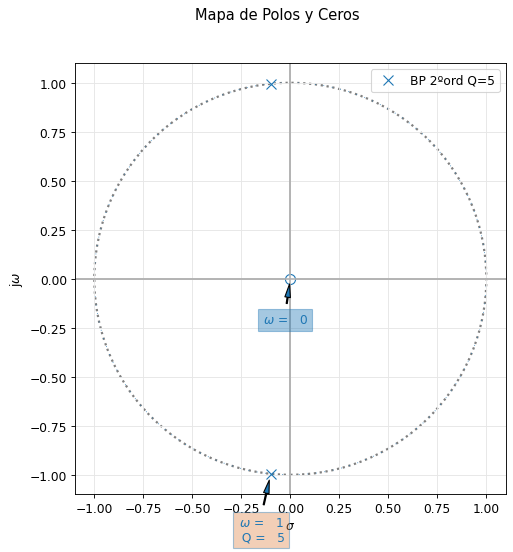

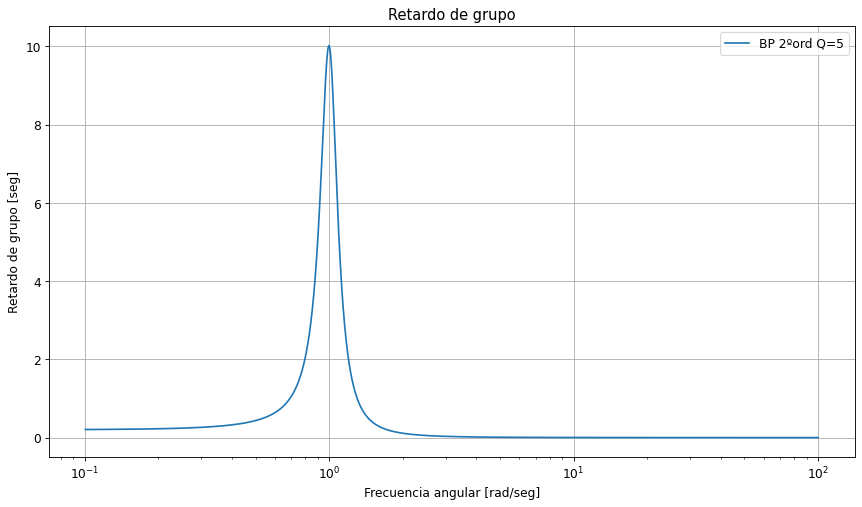

In [7]:
T1_bp =  sig.TransferFunction( num_pbanda, den_pbanda )

# el caracter "_" descarta la salida de la función
_= analyze_sys([T1_bp], sys_name='BP 2ºord Q={:d}'.format(Q_bp))


y con la corroboración numérica se culmina el análisis del primer orden para continuar con los órdenes superiores.

## Prototipo pasabajos de segundo orden

En este caso, la función transferencia *prototipo* será

$$ T_{lp} = \frac{k.b}{p^2 + p.a + b}, $$

siendo $a, b$ y $k$ coeficientes reales y positivos. Procediendo del mismo modo

$$ T_{bp}(s) = T_{lp}(p)\Big\vert_{p = K_{bp}} $$

llegaremos a una función pasabanda de orden 4, para lo cual utilizaremos las posibilidades que da el análisis simbólico y pondremos foco en los parámetros de sendos pasabanda:

In [8]:

H2 = k*b/(s**2 + s*a + b)

H2bp = sp.simplify(sp.expand(H2.subs(s, Kbp)))

num2_bp, den2_bp = sp.fraction(H2bp)

num2_bp = sp.Poly(num2_bp, s)

den2_bp = sp.Poly(den2_bp,s)

den_bp_lc = den2_bp.LC()
den2_bp = den2_bp.monic()

#print_latex(sp.latex(num2_bp/den_bp_lc * 1/den2_bp))

print_latex(a_equal_b_latex_s('T_{bp}(s)', sp.latex(num2_bp/den_bp_lc * 1/den2_bp)))


<IPython.core.display.Math object>

### Análisis de los pasabandas resultantes

Lamenatablemente no es sencillo ordenar los polinomios como uno está acostumbrado a escribirlos, pero si se presta atención, se notará que existe simetría en los valores de los coeficientes del denominador. Luego plantearemos la siguiente factorización, para llegar a la equivalencia de los coeficientes:


$$ T_{bp}(s) = \frac{s^2.k.b}{s^4 + s^3 . \frac{a}{Q_{bp}} + s^2 . \frac{2Q^2_{bp}+b}{Q^2_{bp}} + s . \frac{a}{Q_{bp}} + 1}  = \frac{s.k_1.\omega_1^2}{s^2+s\frac{\omega_1}{Q_1}+\omega_1^2} . \frac{s.k_2.\omega_2^2}{s^2+s\frac{\omega_2}{Q_2}+\omega_2^2}  $$


In [16]:

w_o1, w_o2, qq1, qq2 = sp.symbols("w_1, w_2, q_1, q_2", complex = False)

# planteando la distributiva
den1 = s**2 + s*w_o1/qq1 + w_o1**2
den2 = s**2 + s*w_o2/qq2 + w_o2**2

den4 = den1 * den2

den4 = sp.Poly(den4,s)

den4_coeffs = den4.all_coeffs()

#print_latex(sp.latex(den4.expr))

print_subtitle('Se igualan los coeficientes en ambos miembros')

print_latex(a_equal_b_latex_s(sp.latex(den4.expr), sp.latex(den2_bp.expr)))

# coef s^0
#print_latex(sp.latex(den4_coeffs[-1]))


#### Se igualan los coeficientes en ambos miembros

<IPython.core.display.Math object>

para luego plantear un sistema de ecuaciones, que describe el comportamiento de la transformación. Comenzamos por el coeficiente de $s^0$, posiblemente el más evidente

$$ \omega_1^2 .\omega_2^2 = 1 $$

es decir que 

$$ \omega_1 = \frac{1}{\omega_2} $$

Esta es una primer relación muy importante entre las frecuencias centrales de ambos pasabanda, se encuentran geométricamente centradas respecto a la $\omega_0=1$ del núcleo de la transformación $K_{bp}(s)$.

Luego, del mismo modo, analizando las restricciones de los coeficientes de primer y tercer orden surge que


In [24]:

c3 = den4_coeffs[1]

c1 = den4_coeffs[3]

# substituimos la relación obtenida
c3 = c3.subs(w_o2, 1/w_o1)
c1 = c1.subs(w_o2, 1/w_o1)

# coef s^3
print_subtitle('del coeficiente $s^3$')
print_latex(a_equal_b_latex_s(r'\frac{a}{Q_{bp}}', sp.latex(c3)))

# coef s
print_subtitle('del coeficiente $s^1$')
print_latex(a_equal_b_latex_s(r'\frac{a}{Q_{bp}}', sp.latex(c1)))


#### del coeficiente $s^3$

<IPython.core.display.Math object>

#### del coeficiente $s^1$

<IPython.core.display.Math object>

Es decir que la igualdad que debe darse será

$$  \frac{ \frac{q_1}{\omega_1} + q_2.\omega_1}{q_1.q_2} = \frac{ \frac{q_2}{\omega_1} + q_1.\omega_1}{q_1.q_2} = \frac{a}{Q_{bp}} $$

$$  \frac{ \omega_2 - \omega_1}{q_1} = \frac{ \omega_2 - \omega_1}{q_2} $$


Lo cual indica finalmente que $q_1 = q_2 = q$.

Continuando con el análisis de los coeficientes se puede llegar a expresiones de $q$ y $\omega_2$ (Ver Schaumann 9.2):

$$ q^2 = \frac{Q_{bp}}{a} \left( \frac{2Q_{bp}}{a} + \frac{b}{2aQ_{bp}} \pm \sqrt{\left( \frac{2Q_{bp}}{a} + \frac{b}{2aQ_{bp}} \right)^2 - 1} \right) $$

$$ \omega_2 =\frac{1}{\omega_1}= \frac{a q}{2 Q_{bp}} + \frac{1}{2} \sqrt{\frac{b}{Q_{bp}^2} - \frac{1}{q^2}}$$

Si bien no son expresiones sencillas, ni mucho menos prácticas para su memorización, podemos obterner alguna aproximación bajo algunas asunciones del prototipo pasabajo:

- $ a = \frac{\omega_0}{Q_{lp}} = \frac{1}{Q_{lp}} $ 
- $ b = \omega_0^2 = 1 $

Esto significa que, si el prototipo pasabajo también está normalizado, el único parámetro libre del prototipo será el $Q_{lp}$. Entonces una aproximación razonable sería:

$$ q \approx 2 Q_{bp} Q_{lp}, $$

 luego

$$ \omega_2 \approx 1 + \frac{1}{2 Q_{bp}}. $$

De esta manera, solo queda evaluar si esta aproximación es razonable para el filtro bajo diseño. En caso que no sea razonable, resultaría un problema absolutamente numérico, como veremos a continuación.


### Conclusiones para prototipos de segundo orden

Podemos concluir entonces que para un *prototipo pasabajo de segundo orden* 

* se obtendrá una función transferencia pasabanda de orden 4 normalizada ($\omega_0 = 1$).
* la transferencia podrá entenderse como la cascada de dos pasabandas de segundo orden.
* cada pasabanda tendrá pulsaciones recíprocas $\omega_1 = \frac{1}{\omega_2}$
* ambos pasabanda tendrán igual factor de selectividad Q, es decir $q_1 = q_2 = q$

Estas observaciones se pueden expresar matemáticamente como

$$ T_{bp}(s) = \frac{s^2.k.b}{s^4 + s^3 . \frac{a}{Q_{bp}} + s^2 . \frac{2Q^2_{bp}+b}{Q^2_{bp}} + s . \frac{a}{Q_{bp}} + 1}  = k.\frac{s.\omega_1^2}{s^2+s\frac{\omega_1}{q}+\omega_1^2} . \frac{\frac{s}{\omega_1^2}}{s^2+s\frac{1}{q.\omega_1}+\frac{1}{\omega^2_1}}  $$

Luego si la pulsación natural del prototipo es unitaria $b=1$, las siguientes aproximaciones son válidas:

* $ q \approx 2 Q_{bp} Q_{lp} $
* $ \omega_2 \approx 1 + \frac{1}{2 Q_{bp}} $


A continuación finalizaremos la explicación mediante la simulación numérica

### Análisis numérico

Se comienza como en el caso anterior, cargando los coeficientes del prototipo pasabajo. Luego de definir los parámetros de la transformación pasabanda, que serán los mismos para poder comprararlos, se procede a la transformación numérica del prototipo.

In [25]:
# coeficientes de la transferencia de primer orden T1
T2_num = np.array([1])
T2_den = np.array([1, np.sqrt(2), 1])

# Q de la transformación
Q_bp = 5

# núcleo LP-BP
num_pbanda, den_pbanda = sig.lp2bp(T2_num, T2_den, bw = 1/Q_bp)

print_subtitle('Prototipo de segundo orden')

print_latex(a_equal_b_latex_s('$ T_{lp}(s)', sp.latex( 1/(s**2 + s * sp.sqrt(2) + 1) )))

#display(Markdown('### Filtro pasabanda cuarto orden normalizado Q ={:d}'.format(Q_bp) ))

print_subtitle('Pasabanda obtenido (coeficientes de los polinomios)')

print(num_pbanda)
print(den_pbanda)



#### Prototipo de segundo orden

<IPython.core.display.Math object>

#### Pasabanda obtenido (coeficientes de los polinomios)

[0.04 0.   0.  ]
[1.         0.28284271 2.04       0.28284271 1.        ]


misma observación que en el caso anterior, con los coeficientes no podemos extraer la información que necesitamos con facilidad. Le damos una vuelta algebraica y se obtiene

In [20]:

print_subtitle('Pasabanda visto como cociente de polinomios')

# forma un poco más clara
#pretty_print_lti(num_pbanda, den_pbanda)
print_latex(a_equal_b_latex_s('T_{bp}(s)', pretty_print_lti(num_pbanda, den_pbanda, displaystr=False)))


#### Pasabanda visto como cociente de polinomios

<IPython.core.display.Math object>

que en el caso de órdenes mayores a dos tampoco es lo suficientemente claro. Por ello se enfatiza la necesidad de factorizar y parametrizar para ganar una mejor perspectiva del funcionamiento del filtro

In [22]:
# esta es la que va

print_subtitle('Pasabanda factorizado en secciones bicuadráticas (SOS)')

sos_pbanda = tf2sos_analog(num_pbanda, den_pbanda)

# la visualizamos de algunas formas, la tradicional
#pretty_print_SOS(sos_pbanda)
print_latex(a_equal_b_latex_s('T_{bp}(s)', pretty_print_SOS(sos_pbanda, displaystr=False)))


#### Pasabanda factorizado en secciones bicuadráticas (SOS)

<IPython.core.display.Math object>

como se puede observar, la factorización ayuda, pero no es suficiente

In [31]:
print_subtitle('Pasabanda factorizado en SOS parametrizadas $\omega_0$ y $Q$')

#pretty_print_SOS(sos_pbanda, mode='omegayq')
print_latex(a_equal_b_latex_s('T_{bp}(s)', pretty_print_SOS(sos_pbanda, mode='omegayq', displaystr=False)))


#### Pasabanda factorizado en SOS parametrizadas $\omega_0$ y $Q$

<IPython.core.display.Math object>

Nuevamente se enfatiza la similitud con la expresión original de la transferencia pasabanda general

$$ T_{bp}(s) = \frac{s . k . \frac{\omega_0}{Q_{bp}} }{s^2 + s . \frac{\omega_0}{Q_{bp}} + \omega_0^2} $$

Para luego identificar los parámetros de cada SOS

#### SOS1

* $ \omega_0 = 1.073 $
* $ Q = 7.09 $
* $ K = 1.03 $

#### SOS2

* $ \omega_0 = 0.932 $
* $ Q = 7.09 $
* $ K = 1.94 $


![messi_campeon](messi_campeon.jpg)

### Análisis de la respuesta en frecuencia

Procedemos finalmente a analizar la transferencia pasabanda completa de forma numérica

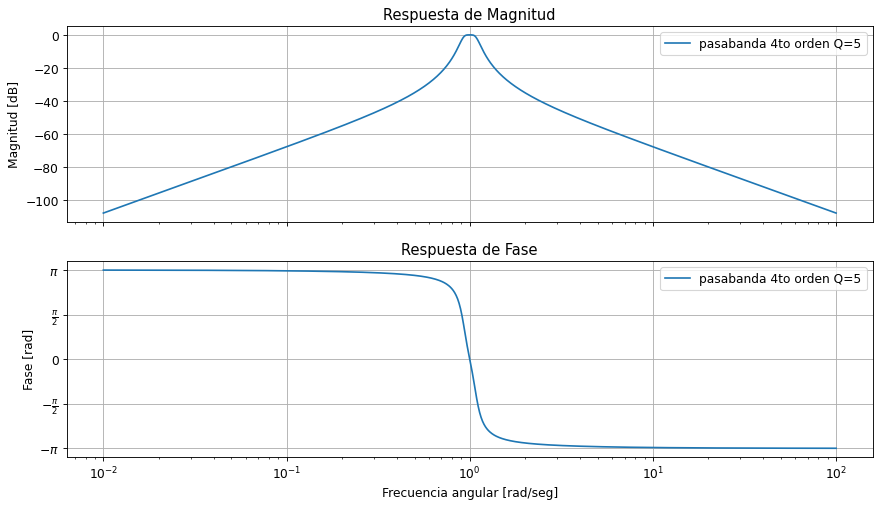

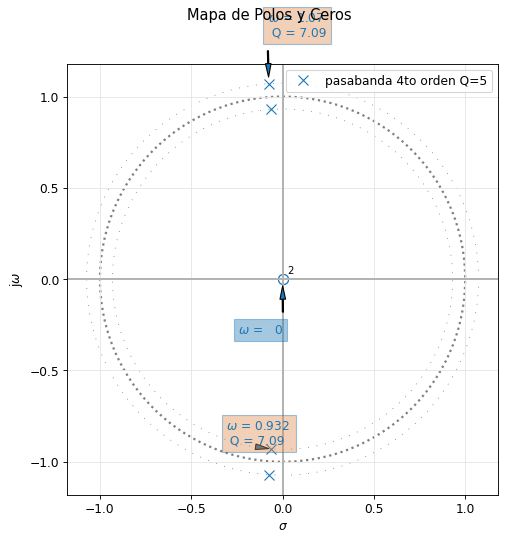

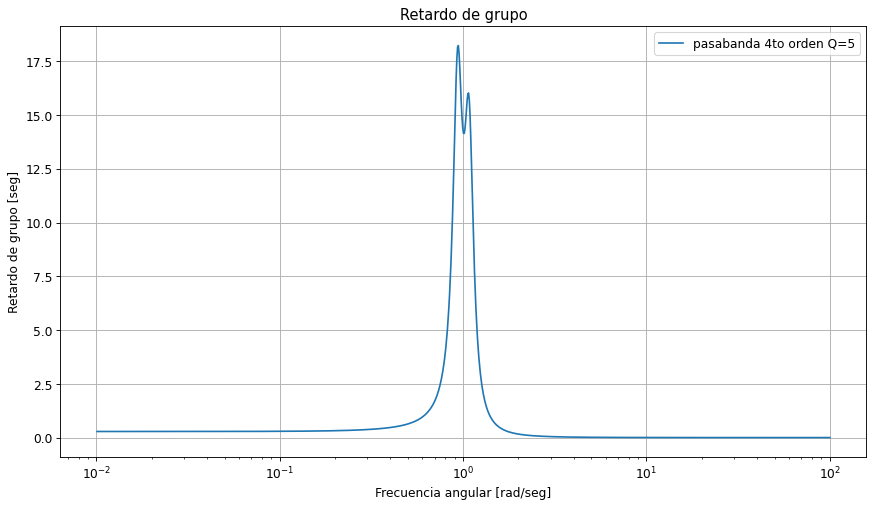

In [15]:
T1_bp =  sig.TransferFunction( num_pbanda, den_pbanda )

# el caracter "_" descarta la salida de la función
_ = analyze_sys(T1_bp, sys_name='pasabanda 4to orden Q={:d}'.format(Q_bp))


Notar en el diagrama de polos y ceros las observaciones que se hicieron más arriba:

* $ \omega_1 = 1.073 $ y $ q_1 = 7.09 $
* $ \omega_2 = 0.932 $ y $ q_2 = 7.09 $
* $ \omega_1 = \frac{1}{\omega_2} $

Se deja para quien lea y tenga interés, verificar en el diagrama de módulo el ancho de banda del filtro implementado:

$$ \mathrm{BW} = \frac{1}{Q_{bp}} = 0.2 $$

Como observación final, revisamos los resultados que arrojan las aproximaciones propuestas

* $ q_1 = q_2 = \approx 2 Q_{bp} Q_{lp} =  2 . 5 . \frac{\sqrt{2}}{2} = 7.07 $
* $ \omega_2 \approx 1 + \frac{1}{2 Q_{bp}} = 1.1$
* $ \omega_1 \approx \frac{1}{1.1} = 0.9$

